In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons
!pip install pyyaml h5py
!pip install toolz scikit-allel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.0 MB/s eta 0:00:00


In [3]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


## Setup

In [4]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.12.0


## Hardware Config

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on TPU  grpc://10.30.0.186:8470


N_REPLICAS: 8


## Prepare the data

In [6]:
root_dir = '[data_dir]/'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.full.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.full.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=None)
info = genotypes.iloc[:-1, :9]
genotypes = genotypes.iloc[:-1, 9:].T
headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,1|1,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21143,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [7]:
ped_file = '[data_dir]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [8]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [9]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2504,)

In [10]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2504, 572)

In [11]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 572)

### MAF

In [12]:
def get_max_genotype(g):
  v1, v2 = g.split("|")
  return max(int(v1), int(v2)) + 1

def key_gen(v1, v2):
  return f"{v1}|{v2}"

In [13]:
def maf_mapper(txt):
  af = min(list(map(lambda x: float(x), txt.split(";")[1].split("=")[1].split(","))))
  return min(af, 1-af)

In [14]:
mafs = info.iloc[:, 7:8].applymap(maf_mapper)
mafs

,INFO
0,0.024960
1,0.005791
2,0.037141
3,0.000399
4,0.000399
...,...
567,0.000799
568,0.000599
569,0.023562
570,0.000200


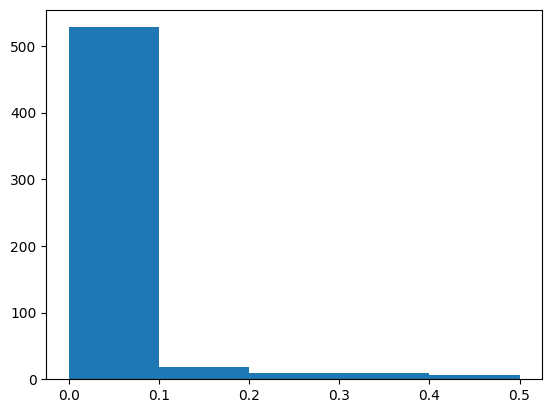

In [15]:
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5]);

In [16]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=False)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([528,  18,  10,  10,   6]))

In [17]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 3
learning_rate = 0.001
weight_decay = 0.00001
embed_dim = 64  # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
regularization_coef_l1 = 1e-5
batch_size = 20
dropout_rate = 0.25

## Convert to tensorflow dataset

In [18]:
@tf.function()
def add_attention_mask(X_sample, y_sample):
  depth = 3
  mask_size = tf.cast(X_sample.shape[0]*0.5, dtype=tf.int64)
  mask_idx = tf.reshape(tf.random.shuffle(tf.range(X_sample.shape[0]))[:mask_size], (-1, 1))
  updates = tf.math.add(tf.ones(shape=(mask_idx.shape[0]), dtype=tf.int64), 1)
  X_masked = tf.tensor_scatter_nd_update(X_sample, mask_idx, updates)
  return tf.one_hot(X_masked, depth), tf.one_hot(y_sample, depth-1)

In [19]:
def map_values_1(x):
  return 0 if (x == 0 or x == 1) else 1

def map_values_2(x):
  return 0 if (x == 0 or x == 2) else 1

def get_dataset(x, chunk_start, chunk_end, start_offset, end_offset, batch_size, training=True):
  AUTO = tf.data.AUTOTUNE

  _x = np.empty((x.shape[0] * 2, chunk_end-chunk_start), dtype=x.dtype)

  map_values_1_vec = np.vectorize(map_values_1)
  map_values_2_vec = np.vectorize(map_values_2)

  _x[0::2] = map_values_1_vec(x[:, chunk_start:chunk_end])
  _x[1::2] = map_values_2_vec(x[:, chunk_start:chunk_end])
  new_chunk_end = _x.shape[1]

  dataset = tf.data.Dataset.from_tensor_slices((_x,
                                                _x[:, start_offset:new_chunk_end-end_offset]))

  if training:
    dataset = dataset.shuffle(_x.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.repeat()

  # Add Attention Mask
  dataset = dataset.map(add_attention_mask, num_parallel_calls=AUTO, deterministic=False)

  # Prefetech to not map the whole dataset
  dataset = dataset.prefetch(AUTO)

  dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)

  return dataset

## Model

In [20]:
kr = 1e-6
drop_prec = 0.25

In [21]:
def createSCDA(base_size=128, kernel_size=32):
  inputt = layers.Input(shape=(feature_size, inChannel))
  # encoder
  x = layers.Conv1D(base_size, kernel_size, padding='same',activation='relu',
                        kernel_regularizer=regularizers.l1(kr),
                        input_shape=(feature_size, inChannel))(inputt)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(drop_prec)(x)
  x = layers.Conv1D(base_size*2, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(drop_prec)(x)

  # bridge
  x = layers.Conv1D(base_size*4, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)

  # decoder
  x = layers.Conv1D(base_size*2, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)
  x = layers.BatchNormalization()(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.Dropout(drop_prec)(x)

  x = layers.Conv1D(base_size, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)
  x = layers.BatchNormalization()(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.Dropout(drop_prec)(x)

  x = layers.Conv1D(inChannel-1, kernel_size, activation='softmax', padding='same')(x)
  #   x = layers.Dense(inChannel-1, activation=tf.nn.softmax)(x)

  SCDA = tf.keras.models.Model(inputt, x)

  return SCDA

In [22]:
model = createSCDA()
model.build((1, feature_size, inChannel))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 572, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 572, 128)          12416     
                                                                 
 batch_normalization (BatchN  (None, 572, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 286, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 286, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 256)          104883

In [23]:
def create_model():
  model =  createSCDA()
  optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate)
  model.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())
  return model

In [24]:
METRIC = "val_categorical_accuracy"

def create_callbacks(kfold=0, metric = METRIC):

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='auto',
        factor=0.2,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience= 10,
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [
                 reducelr,
                 earlystop]

    return callbacks

In [25]:
np.unique(Y_train.values)

array(['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN',
       'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK',
       'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'],
      dtype=object)

## Training

In [26]:
save_dir = "[save_dir]/"

if not os.path.exists(save_dir):
  # shutil.rmtree(save_dir)
  os.makedirs(save_dir)

In [27]:
# A TPU V3-8 has 8 computing cores, the global batch size will be 1/16 x 8 = 8/128
BATCH_SIZE_BASE = 2
# Training configuration
BATCH_SIZE = BATCH_SIZE_BASE * N_REPLICAS if TPU else 5
BATCH_SIZE

16

In [28]:
# With constraint
missing_perc = 0.1
N_SPLITS=3
NUM_EPOCHS = 1000
accuracies = []
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1

  print(f"Training using fold {fold}")
  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True)

  steps_per_epoch = 2*x_train.shape[0]//BATCH_SIZE
  validation_steps = 2*x_valid.shape[0]//BATCH_SIZE
  train_dataset = get_dataset(x_train, 0, feature_size, 0, 0, BATCH_SIZE)
  valid_dataset = get_dataset(x_valid, 0, feature_size, 0, 0, BATCH_SIZE, training=False)

  K.clear_session()
  callbacks = create_callbacks()
  with strategy.scope():
    model = create_model()
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS,
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks, verbose=1)
  for missing_perc in [
                         0.05,
                         0.1,
                         0.2
                         ]:
    save_name = save_dir + f"preds_mixed_mr_{missing_perc}_fold_{fold}_probs"
    avg_accuracy = []
    preds = []
    true_labels = []

    # to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.empty((test_dataset[0].shape[0] * 2, test_dataset[0].shape[1]), dtype=test_dataset[0].dtype)
    map_values_1_vec = np.vectorize(map_values_1)
    map_values_2_vec = np.vectorize(map_values_2)
    test_X_missing[0::2] = map_values_1_vec(test_dataset[0])
    test_X_missing[1::2] = map_values_2_vec(test_dataset[0])
    test_X_missing = to_categorical(test_X_missing, 3)

    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i*2:i*2+2, missing_index, :] = [0, 0, 1]
      # mMask = np.tile(attention_mask, (1, 1, 1))
      # predict
    predict_onehots = model.predict(test_X_missing, verbose=0)
    to_save_array = np.copy(predict_onehots)
    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      predict_missing_onehot = predict_onehots[i*2:(i+1)*2, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      predict_missing_final = np.zeros((1, predict_missing.shape[1]))
      for j in range(predict_missing.shape[1]):
        if predict_missing[:, j].tolist() == [0, 0]:
          predict_missing_final[:, j] = 0
        elif predict_missing[:, j].tolist() == [0, 1]:
          predict_missing_final[:, j] = 1
        elif predict_missing[:, j].tolist() == [1, 0]:
          predict_missing_final[:, j] = 2
        elif predict_missing[:, j].tolist() == [1, 1]:
          predict_missing_final[:, j] = 3
        else:
          predict_missing_final[:, j] = 4
      preds.extend(predict_missing_final.ravel().tolist())

      # predict_haplotypes = np.argmax(predict_onehots[i*2:(i+1)*2], axis=2)
      # for j in range(predict_onehots.shape[1]):
      #   if predict_haplotypes[:, j].tolist() == [0,0]:
      #     to_save_array[i, j] = '0|0'
      #   elif predict_haplotypes[:, j].tolist() == [0,1]:
      #     to_save_array[i, j] = '0|1'
      #   elif predict_haplotypes[:, j].tolist() == [1,0]:
      #     to_save_array[i, j] = '1|0'
      #   elif predict_haplotypes[:, j].tolist() == [1, 1]:
      #     to_save_array[i, j] = '1|1'
      #   else:
      #     to_save_array[i, j] = '.|.'
      # real label
      label_missing_onehot = test_dataset[0][i:i + 1, missing_index]
      # label_missing = np.argmax(label_missing_onehot, axis=2)
      label_missing = test_dataset[0][i:i + 1, missing_index]
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing_final, label_missing)
      accuracy = np.mean(correct_prediction)
      # print('{}/{}, accuracy: {:.4f}'.format(
      #     i, test_X_missing.shape[0], accuracy))

      avg_accuracy.append(accuracy)

    # df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    # df.to_csv(save_name)
    np.save(save_name, to_save_array)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_perc, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
  print(f"=====================================")



Training using fold 1
Epoch 1/1000
187/187 [==============================] - 37s 49ms/step - loss: 0.5610 - categorical_accuracy: 0.8202 - val_loss: 7.1264 - val_categorical_accuracy: 0.0776 - lr: 0.0010
Epoch 2/1000
187/187 [==============================] - 5s 27ms/step - loss: 0.1851 - categorical_accuracy: 0.9771 - val_loss: 27.3990 - val_categorical_accuracy: 0.0261 - lr: 0.0010
Epoch 3/1000
187/187 [==============================] - 5s 29ms/step - loss: 0.1456 - categorical_accuracy: 0.9838 - val_loss: 12.1879 - val_categorical_accuracy: 0.1094 - lr: 0.0010
Epoch 4/1000
187/187 [==============================] - 6s 30ms/step - loss: 0.1352 - categorical_accuracy: 0.9858 - val_loss: 0.9308 - val_categorical_accuracy: 0.6118 - lr: 0.0010
Epoch 5/1000
187/187 [==============================] - 5s 28ms/step - loss: 0.1301 - categorical_accuracy: 0.9864 - val_loss: 0.1220 - val_categorical_accuracy: 0.9877 - lr: 0.0010
Epoch 6/1000
187/187 [==============================] - 5s 28ms/s

100%|██████████| 835/835 [00:08<00:00, 103.14it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9533: 
Sensitivity: 0.3819668763502929
Specificity: 0.7994781905381687
F1-score macro: 0.4149961861143865
F1-score micro: 0.9532934131736527


100%|██████████| 835/835 [00:03<00:00, 229.82it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9635: 
Sensitivity: 0.36996869207196337
Specificity: 0.7980550360555335
F1-score macro: 0.41661644347397786
F1-score micro: 0.9635255804181111


100%|██████████| 835/835 [00:04<00:00, 193.49it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9613: 
Sensitivity: 0.3826106786964111
Specificity: 0.8087678406991397
F1-score macro: 0.4328703392496326
F1-score micro: 0.9613089610253178
Training using fold 2
Epoch 1/1000
187/187 [==============================] - 16s 31ms/step - loss: 0.5308 - categorical_accuracy: 0.8361 - val_loss: 11.8005 - val_categorical_accuracy: 0.0379 - lr: 0.0010
Epoch 2/1000
187/187 [==============================] - 7s 40ms/step - loss: 0.1770 - categorical_accuracy: 0.9776 - val_loss: 28.9132 - val_categorical_accuracy: 0.0250 - lr: 0.0010
Epoch 3/1000
187/187 [==============================] - 9s 48ms/step - loss: 0.1463 - categorical_accuracy: 0.9840 - val_loss: 12.9599 - val_categorical_accuracy: 0.1071 - lr: 0.0010
Epoch 4/1000
187/187 [==============================] - 8s 43ms/step - loss: 0.1367 - categorical_accuracy: 0.9857 - val_loss: 0.4495 - val_categorical_accuracy: 0.8236 - lr: 0.0010
Epoch 5/1000
187/187 [=======

100%|██████████| 835/835 [00:03<00:00, 272.05it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9672: 
Sensitivity: 0.3716005839529957
Specificity: 0.7938948953133345
F1-score macro: 0.42599338069892567
F1-score micro: 0.9672369546621044


100%|██████████| 835/835 [00:04<00:00, 186.69it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9691: 
Sensitivity: 0.37399045378655926
Specificity: 0.7943914303307101
F1-score macro: 0.42833738673118427
F1-score micro: 0.9691354133837587


100%|██████████| 835/835 [00:03<00:00, 254.74it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9638: 
Sensitivity: 0.3923943774494263
Specificity: 0.8109154704136541
F1-score macro: 0.4423492606867407
F1-score micro: 0.9638092236579473
Training using fold 3
Epoch 1/1000
187/187 [==============================] - 17s 41ms/step - loss: 0.5791 - categorical_accuracy: 0.8088 - val_loss: 8.3242 - val_categorical_accuracy: 0.0642 - lr: 0.0010
Epoch 2/1000
187/187 [==============================] - 5s 27ms/step - loss: 0.1911 - categorical_accuracy: 0.9764 - val_loss: 30.4213 - val_categorical_accuracy: 0.0322 - lr: 0.0010
Epoch 3/1000
187/187 [==============================] - 5s 28ms/step - loss: 0.1468 - categorical_accuracy: 0.9837 - val_loss: 16.5136 - val_categorical_accuracy: 0.0837 - lr: 0.0010
Epoch 4/1000
187/187 [==============================] - 6s 30ms/step - loss: 0.1353 - categorical_accuracy: 0.9859 - val_loss: 0.9980 - val_categorical_accuracy: 0.5915 - lr: 0.0010
Epoch 5/1000
187/187 [========

100%|██████████| 834/834 [00:03<00:00, 257.69it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9662: 
Sensitivity: 0.3952091611349453
Specificity: 0.8036617474841192
F1-score macro: 0.45262369269740094
F1-score micro: 0.9662127440904419


100%|██████████| 834/834 [00:03<00:00, 245.88it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9681: 
Sensitivity: 0.3986546740248354
Specificity: 0.8006344165801942
F1-score macro: 0.4549404584836453
F1-score micro: 0.9681307585510539


100%|██████████| 834/834 [00:03<00:00, 268.64it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9628: 
Sensitivity: 0.4015185352000059
Specificity: 0.8126043482480341
F1-score macro: 0.4514526929545036
F1-score micro: 0.9628192183095629


In [ ]:
from google.colab import runtime
runtime.unassign()